<a href="https://colab.research.google.com/github/carbotton/tdl_tarea_1/blob/eda_preproc_data-aug/Tarea_1_letra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 1 - Taller de Deep Learning

**Fecha de entrega: 19/10/2025**  
**Puntaje máximo: 15**

## Introducción

El objetivo de esta tarea es evaluar su conocimiento sobre Deep Learning aplicado a un caso de uso real. En particular, vamos a evaluar la performance de sus modelos en una tarea de clasificación de escenas.

**Dataset**

El dataset a ser utilizado es **Imagenette**, una versión simplificada de ImageNet que consiste de 10 clases. Pueden encontrar más información y descargarlo en el siguiente [link](https://pytorch.org/vision/main/generated/torchvision.datasets.Imagenette.html).

**Tarea**

Tienen total libertad sobre cómo implementar y resolver el problema así como las técnicas y herramientas que quieran usar. Recomendamos usar Colab por simplicidad, pero pueden implementarlo en sus máquinas si así lo prefieren. La única limitante es que esperamos que la entrega sea en formato .ipynb (Jupyter Notebook) **con las celdas ya ejecutadas**.

**Restricciones**

- No se permite utilizar models pre-entrenados (cada modelo debe ser implementado desde cero)
- Se requiere que utilicen al menos 2 técnicas de **regularización** (Dropout, BatchNorm, Data Augmentation, etc.)
- Se requiere realizar un **análisis de los datos**, que incluya el balanceo de clases y tomar decisiones en base al análisis realizado.
- Las decisiones tomadas sobre el preprocesamiento de las imágenes (transforms, augmentation, etc.) deben ser resultado de la exploración del dataset y estar propiamente justificadas (una sección de exploración en el notebook con comentarios es suficiente).

**Reporte**

En particular, les pedimos que reporten: accuracy, precision, recall y f1.
También se espera poder observar la evolución del modelo (en los datos de train y validación) a medida que se entrena (logs, gráficas, etc).

**Evidencia de Experimentos**

Además, deben presentar evidencia de correr experimentos usando [Weights & Biases (wandb)](https://wandb.ai/). Esto incluye:
- Registros detallados de los experimentos.
- Gráficas y logs de entrenamiento.
- Comparaciones entre diferentes configuraciones de modelos.

In [9]:
!pip install torchinfo

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import v2 as T
from torchvision.io import read_image, ImageReadMode

from torchinfo import summary

import os
from pathlib import Path

from utils import (
    train,
    evaluate,
    model_calassification_report,
    show_tensor_image,
    show_tensor_images,
    plot_taining,
    EarlyStopping,
    print_log,
)

In [11]:
# Fijamos la semilla para que los resultados sean reproducibles
SEED = 34

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [12]:
import sys

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS
elif torch.xpu.is_available():
    DEVICE = "xpu"  # si no hay GPU, pero hay XPU, usamos XPU

print(f"Usando {DEVICE}")

NUM_WORKERS = 0 # Win y MacOS pueden tener problemas con múltiples workers
if sys.platform == 'linux':
    NUM_WORKERS = 4  # numero de workers para cargar los datos (depende de cada caso)

print(f"Usando {NUM_WORKERS}")

Usando cuda
Usando 4


In [13]:
BATCH_SIZE = 128  # tamaño del batch

# Exploracion de datos

El EDA es uno solo, la gracia seria hacerlo con el dataset sin transforms

## Carga de datos

In [36]:
DATA_DIR = Path("data")

# cargamos train y lo dividimos en train y val
imagenette_full_train = datasets.Imagenette(
    DATA_DIR, split="train", download=True
)

train_size = int(0.8 * len(imagenette_full_train))
val_size = len(imagenette_full_train) - train_size

imagenette_train_dataset, imagenette_val_dataset = random_split(
    imagenette_full_train, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # para reproducibilidad
)

# val dataset -> lo usamos como test
imagenette_test_dataset = datasets.Imagenette(
    DATA_DIR, split="val", download=False
)

In [15]:
name_classes = imagenette_full_train.classes # no puedo usar imagenette_train_dataset.classes porque es un subset (surge de haber hecho el random split, no tengo mas atributos de clase ahi
nclasses = len(name_classes)

print(f"Clases: {name_classes}")

Clases: [('tench', 'Tinca tinca'), ('English springer', 'English springer spaniel'), ('cassette player',), ('chain saw', 'chainsaw'), ('church', 'church building'), ('French horn', 'horn'), ('garbage truck', 'dustcart'), ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'), ('golf ball',), ('parachute', 'chute')]


## Numero de clases y cantidad de imagenes por clase

Todas tienen cantidades similares de imágenes.

Entre la clase que menos tiene y la que más, hay una diferencia de 135 imagenes.

In [16]:
root_dir = "data/imagenette2/train"
classes = os.listdir(root_dir)

class_counts = {}
for cls in classes:
    n_images = len(os.listdir(os.path.join(root_dir, cls)))
    class_counts[cls] = n_images
    print(f"{cls}: {n_images} imágenes")

# Encontrar la clase con menos y más imágenes
min_class = min(class_counts, key=class_counts.get)
max_class = max(class_counts, key=class_counts.get)

print(f"\nClase con MENOS imágenes: {min_class} ({class_counts[min_class]} imágenes)")
print(f"Clase con MÁS imágenes:  {max_class} ({class_counts[max_class]} imágenes)")
print(f"\nLa clase {max_class} tiene {((class_counts[max_class]-class_counts[min_class])/class_counts[max_class])*100:.1f}% más de imágenes que la clase {min_class}")


n03425413: 931 imágenes
n01440764: 963 imágenes
n02979186: 993 imágenes
n03888257: 960 imágenes
n03000684: 858 imágenes
n03445777: 951 imágenes
n02102040: 955 imágenes
n03028079: 941 imágenes
n03394916: 956 imágenes
n03417042: 961 imágenes

Clase con MENOS imágenes: n03000684 (858 imágenes)
Clase con MÁS imágenes:  n02979186 (993 imágenes)

La clase n02979186 tiene 13.6% más de imágenes que la clase n03000684


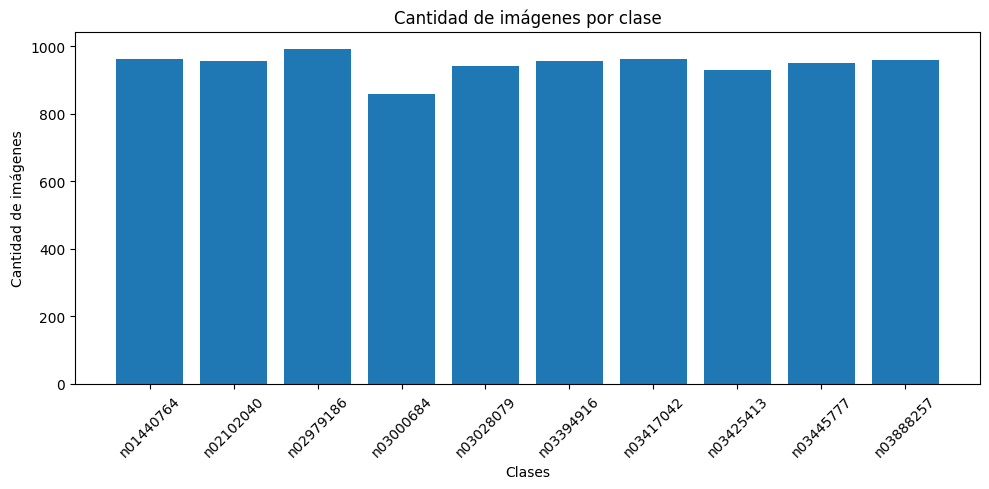

In [17]:
import matplotlib.pyplot as plt

# Ordenar clases para que el gráfico quede prolijo
sorted_classes = sorted(class_counts.keys())
sorted_counts = [class_counts[cls] for cls in sorted_classes]

plt.figure(figsize=(10, 5))
plt.bar(sorted_classes, sorted_counts)
plt.xticks(rotation=45)
plt.xlabel("Clases")
plt.ylabel("Cantidad de imágenes")
plt.title("Cantidad de imágenes por clase")
plt.tight_layout()
plt.show()


## Ver selección random de imágenes

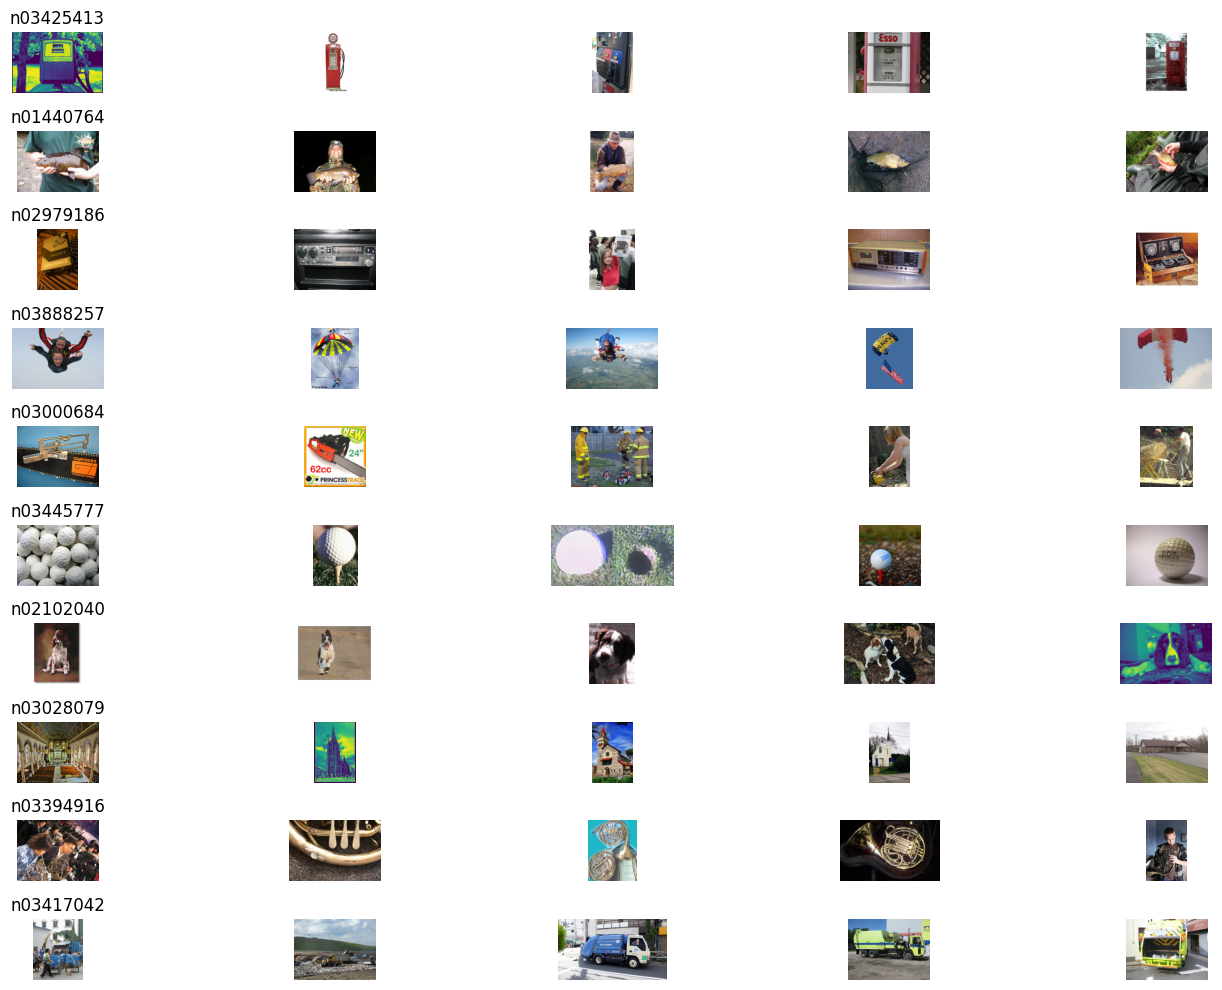

In [18]:
import random
import matplotlib.image as mpimg

n_samples = 5
fig, axs = plt.subplots(len(classes), n_samples, figsize=(15, 10))

for i, cls in enumerate(classes):
    img_files = os.listdir(os.path.join(root_dir, cls))
    for j in range(n_samples):
        img_path = os.path.join(root_dir, cls, random.choice(img_files))
        img = mpimg.imread(img_path)
        axs[i, j].imshow(img)
        axs[i, j].axis("off")
        if j == 0:
            axs[i, j].set_title(cls)
plt.tight_layout()
plt.show()


## Ver tamaños de imágenes

Se puede observar que el tamaño de las imágenes difiere mucho entre una y otra.

In [19]:
from PIL import Image

sizes = []
for cls in classes:
    img_files = os.listdir(os.path.join(root_dir, cls))
    for img_file in img_files[:50]:  # muestra
        img_path = os.path.join(root_dir, cls, img_file)
        with Image.open(img_path) as img:
            sizes.append(img.size)  # (ancho, alto)

size_counts = {}
for size in sizes:
    if size not in size_counts:
        size_counts[size] = 0
    size_counts[size] += 1

# Encontrar el tamaño más y menos común
most_common_size = None
most_common_count = -1
least_common_size = None
least_common_count = float('inf')

for size, count in size_counts.items():
    if count > most_common_count:
        most_common_size = size
        most_common_count = count
    if count < least_common_count:
        least_common_size = size
        least_common_count = count

print(f"Tamaño de las imágenes: {sizes}")
print(f"\nTotal de tamaños diferentes encontrados: {len(size_counts)}")
print(f"Tamaño MÁS común: {most_common_size} (aparece {most_common_count} veces)")
print(f"Tamaño MENOS común: {least_common_size} (aparece {least_common_count} veces)")


Tamaño de las imágenes: [(470, 500), (375, 500), (500, 375), (300, 500), (500, 375), (400, 500), (367, 500), (400, 836), (500, 375), (375, 500), (250, 237), (500, 375), (364, 500), (375, 500), (512, 800), (500, 375), (500, 377), (375, 500), (400, 533), (413, 310), (375, 500), (500, 375), (500, 332), (500, 375), (375, 500), (500, 375), (375, 500), (375, 500), (500, 375), (400, 500), (600, 502), (500, 375), (500, 400), (500, 375), (375, 500), (1944, 2592), (500, 375), (500, 500), (500, 375), (678, 435), (167, 500), (375, 500), (500, 377), (375, 500), (500, 336), (500, 375), (375, 500), (500, 653), (344, 599), (500, 375), (280, 320), (383, 575), (275, 225), (599, 465), (275, 206), (223, 146), (320, 256), (500, 375), (500, 381), (580, 523), (400, 300), (500, 332), (500, 412), (333, 500), (432, 324), (400, 300), (328, 250), (400, 300), (500, 331), (400, 300), (500, 375), (500, 375), (400, 284), (500, 375), (512, 384), (369, 276), (500, 377), (500, 375), (500, 333), (1024, 768), (334, 250), 

## Buscar duplicados

In [20]:
import hashlib

def md5(fname):
    with open(fname, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

hashes = {}
duplicates = []
for cls in classes:
    for img_file in os.listdir(os.path.join(root_dir, cls)):
        path = os.path.join(root_dir, cls, img_file)
        h = md5(path)
        if h in hashes:
            duplicates.append(path)
        else:
            hashes[h] = path
print(f"Encontradas {len(duplicates)} imágenes duplicadas.")


Encontradas 0 imágenes duplicadas.


# LeNet

## Carga de datos con transforms para LeNet

**Transforms:**

Preprocessing -> train y val/test

Data augmentation -> solo train

In [21]:
train_tfms_lenet = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=T_MEAN, std=T_STD),
    # AUGMENTATION SOLO EN TRAIN 
    # T.RandomAffine(degrees=10, translate=(0.05,0.05), scale=(0.95,1.05)),
    # T.RandomHorizontalFlip(p=0.5),
    # PREPROCESS:
    T.Resize((32, 32)),
    T.Grayscale(num_output_channels=1),
])

val_tfms_lenet = T.Compose([
    T.ToImage(),
    T.Resize((32, 32)),
    T.Grayscale(num_output_channels=1),
    T.ToDtype(torch.float32, scale=True),
    # T.Normalize(mean=(0.5,), std=(0.5,)),
])

DATA_DIR = Path("data")

# cargamos train y lo dividimos en train y val
imagenette_full_train = datasets.Imagenette(
    DATA_DIR, split="train", download=True, transform=train_tfms_lenet
)
train_size = int(0.8 * len(imagenette_full_train))
val_size = len(imagenette_full_train) - train_size

imagenette_train_dataset, imagenette_val_dataset = random_split(
    imagenette_full_train, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # para reproducibilidad
)

# val dataset -> lo usamos como test
imagenette_test_dataset = datasets.Imagenette(
    DATA_DIR, split="val", download=False, transform=val_tfms_lenet
)


In [22]:
def get_dataloaders(batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    train_loader = DataLoader(
        imagenette_train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

    val_loader = DataLoader(
        imagenette_val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    test_loader = DataLoader(
        imagenette_val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    return train_loader, val_loader, test_loader


train_loader, val_loader, test_loader = get_dataloaders()

## Regularization

Para saber si necesitamos dropout, entrenar una vez y ver si hay overfitting (val_acc=85% agregar ; val_acc=78% no hace falta)

### Data Augmentation
SOLO PARA TRAINING !!!!!!!!!

### Early stopping

Aplicado en training loop

### Dropout

Aplicado en training loop

## Arquitectura del modelo

In [23]:
class LeNet(nn.Module):
    def __init__(self, in_channels, num_classes, use_dropout=False, dropout_p=0.5):
        """
        LeNet clasica con opción de dropout
        """
        
        super(LeNet, self).__init__()

        self.use_dropout = use_dropout
        self.dropout_p = dropout_p
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)
        self.tanh = nn.Tanh()
        self.linear = nn.Linear(120, 84)
        self.output = nn.Linear(84, num_classes)
        self.flatten = nn.Flatten(start_dim=1)

        self.dropout = nn.Dropout(p=self.dropout_p) if self.use_dropout else nn.Identity()


    def forward(self, x):
        x = self.tanh(self.conv1(x))
        x = self.pool(x)
        x = self.tanh(self.conv2(x))
        x = self.pool(x)
        x = self.tanh(self.conv3(x))
        x = self.flatten(x)
        x = self.tanh(self.linear(x))
        x = self.dropout(x) # despues de la activacion
        x = self.output(x)
        return x


summary(LeNet(1, 10), input_size=(BATCH_SIZE, 1, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [128, 10]                 --
├─Conv2d: 1-1                            [128, 6, 28, 28]          156
├─Tanh: 1-2                              [128, 6, 28, 28]          --
├─AvgPool2d: 1-3                         [128, 6, 14, 14]          --
├─Conv2d: 1-4                            [128, 16, 10, 10]         2,416
├─Tanh: 1-5                              [128, 16, 10, 10]         --
├─AvgPool2d: 1-6                         [128, 16, 5, 5]           --
├─Conv2d: 1-7                            [128, 120, 1, 1]          48,120
├─Tanh: 1-8                              [128, 120, 1, 1]          --
├─Flatten: 1-9                           [128, 120]                --
├─Linear: 1-10                           [128, 84]                 10,164
├─Tanh: 1-11                             [128, 84]                 --
├─Identity: 1-12                         [128, 84]                 --
├─L

## Entrenamiento


In [24]:
LR = 0.001
EPOCHS = 10

letnet_model = LeNet(1,10).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(letnet_model.parameters(), lr=LR)

"""epoch_train_errors, epoch_val_errors = train(
    letnet_model,
    optimizer,
    criterion,
    train_loader,
    val_loader,
    DEVICE,
    do_early_stopping=True,
    patience=10,
    epochs=EPOCHS,
    log_fn=print_log,
    log_every=1,
)"""

'epoch_train_errors, epoch_val_errors = train(\n    letnet_model,\n    optimizer,\n    criterion,\n    train_loader,\n    val_loader,\n    DEVICE,\n    do_early_stopping=True,\n    patience=10,\n    epochs=EPOCHS,\n    log_fn=print_log,\n    log_every=1,\n)'

In [25]:
#plot_taining(epoch_train_errors, epoch_val_errors)

In [ ]:
#model_calassification_report(letnet_model, val_loader, DEVICE, nclasses)

## Weight & Biases

In [26]:
import wandb

WANDB_TEAM_NAME = "mc-ort"
WANDB_PROJECT = "Tarea1_LeNet_2"
os.environ["WANDB_NOTEBOOK_NAME"] = "./Tarea_1_letra.ipynb"

wandb.login()

wandb: Currently logged in as: mc241319 (mc-ort) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [27]:
sweep_config = {
    "name": "tarea_1_lenet",
    "method": "random",
    "metric": {"name": "val_macro_f1", "goal": "maximize"},  # o "val_accuracy"
    "parameters": {
        # Optimizador y LR
        "optimizer": {"values": ["adam", "sgd"]},
        "learning_rate": {"distribution": "log_uniform_values", "min": 1e-4, "max": 5e-3},
        "weight_decay": {"values": [0.0, 1e-4, 5e-4]},

        # Regularización en FC
        "dropout_p": {"values": [0.0, 0.2, 0.3]},

        # Data
        "batch_size": {"values": [64, 128, 256]},

        # Early stopping
        "early_stop": {"values": [True, False]},
        "patience": {"values": [3, 5]},   

        # Entrenamiento                
        "label_smoothing": {"values": [0.0, 0.05]},
        "seed": {"values": [7, 13]},
    },
}

sweep_id = wandb.sweep(sweep_config, project=WANDB_PROJECT)

Create sweep with ID: aaxf3yav
Sweep URL: https://wandb.ai/mc-ort/Tarea1_LeNet_2/sweeps/aaxf3yav


In [28]:
def wand_log(epoch, train_loss, val_loss):
    wandb.log({"epoch": epoch + 1, "train_loss": train_loss, "val_loss": val_loss})


In [29]:
import time 

def sweep_run():
    """
    Función que se ejecutará en cada run del sweep.
    """
    # inicializar un nuevo run
    print("[RUN] init", flush=True)
    wandb.init()

    print(f"[RUN] device = {DEVICE}", flush=True)
    
    # leer la configuración del run
    config = wandb.config
    run_learning_rate = config.learning_rate
    run_optimizer = config.optimizer
    run_weight_decay = config.weight_decay
    run_dropout_p = config.dropout_p
    run_batch_size = config.batch_size
    run_early_stopping = config.early_stop
    run_patience = config.patience
    run_label_smoothing = config.label_smoothing

    # modelo
    if run_dropout_p == 0:
        model = LeNet(1,10).to(DEVICE)
    else:
        model = LeNet(1,10,True,run_dropout_p).to(DEVICE)

    # TODO: aca si tiene dropout tengo que volver a armar la red y ponerle las capaz de dropout que quiera, no se hace solo

    # dataloaders
    t0 = time.time()
    print("[RUN] building dataloaders...", flush=True)    
    train_loader, val_loader, test_loader = get_dataloaders(run_batch_size, NUM_WORKERS)
    print(f"[RUN] dataloaders ok in {time.time()-t0:.2f}s", flush=True)

    # optimizer
    if run_optimizer == "adam":
      optimizer = optim.Adam(model.parameters(), lr=run_learning_rate, weight_decay=run_weight_decay)
    elif run_optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=run_learning_rate, momentum=0.9, nesterov=True, weight_decay=run_weight_decay)

    # criterion
    if run_label_smoothing == 0:
        criterion = nn.CrossEntropyLoss().to(DEVICE)
    else:
        criterion = nn.CrossEntropyLoss(label_smoothing=run_label_smoothing).to(DEVICE)

    def log_with_timing(epoch, train_loss, val_loss):
        wandb.log({"epoch": epoch+1, "train_loss": train_loss, "val_loss": val_loss})
        print(f"[EPOCH {epoch+1}] train_loss={train_loss:.4f} val_loss={val_loss:.4f}", flush=True)        

    print("[RUN] starting train...", flush=True)
    train(model, optimizer, criterion, train_loader, val_loader, device=DEVICE, do_early_stopping=run_early_stopping, patience=run_patience,
          epochs=EPOCHS, log_fn=log_with_timing, log_every=1)
    
    # guardo pesos temporalmente
    torch.save(model.state_dict(), "model.pth")
    wandb.save(f"model.pth")

    wandb.finish()

In [30]:
print("DEVICE = ", DEVICE)

DEVICE =  cuda


In [31]:
wandb.agent(sweep_id, function=sweep_run, count=5) # corre sweep_run 10 veces

wandb: Agent Starting Run: mjneyrc2 with config:
wandb: 	batch_size: 256
wandb: 	dropout_p: 0.3
wandb: 	early_stop: True
wandb: 	label_smoothing: 0.05
wandb: 	learning_rate: 0.003623381468913583
wandb: 	optimizer: adam
wandb: 	patience: 3
wandb: 	seed: 7
wandb: 	weight_decay: 0.0001


[RUN] init


[RUN] device = cuda
[RUN] building dataloaders...
[RUN] dataloaders ok in 0.00s
[RUN] starting train...
[EPOCH 1] train_loss=2.1780 val_loss=2.1310
[EPOCH 2] train_loss=2.0981 val_loss=2.1360
[EPOCH 3] train_loss=2.0867 val_loss=2.0844
[EPOCH 4] train_loss=2.0718 val_loss=2.0755
[EPOCH 5] train_loss=2.0536 val_loss=2.0660
[EPOCH 6] train_loss=2.0343 val_loss=2.0641
[EPOCH 7] train_loss=2.0262 val_loss=2.0424
[EPOCH 8] train_loss=2.0058 val_loss=2.0446
[EPOCH 9] train_loss=1.9857 val_loss=2.0040
[EPOCH 10] train_loss=1.9654 val_loss=2.0067


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▅▅▅▄▃▃▂▂▁
val_loss,██▅▅▄▄▃▃▁▁
epoch,10
train_loss,1.96538
val_loss,2.00667


wandb: Agent Starting Run: 90i394y1 with config:
wandb: 	batch_size: 64
wandb: 	dropout_p: 0
wandb: 	early_stop: True
wandb: 	label_smoothing: 0.05
wandb: 	learning_rate: 0.002187539016166085
wandb: 	optimizer: sgd
wandb: 	patience: 3
wandb: 	seed: 13
wandb: 	weight_decay: 0


[RUN] init


[RUN] device = cuda
[RUN] building dataloaders...
[RUN] dataloaders ok in 0.00s
[RUN] starting train...
[EPOCH 1] train_loss=2.3031 val_loss=2.2997
[EPOCH 2] train_loss=2.2957 val_loss=2.2900
[EPOCH 3] train_loss=2.2857 val_loss=2.2761
[EPOCH 4] train_loss=2.2665 val_loss=2.2512
[EPOCH 5] train_loss=2.2314 val_loss=2.2162
[EPOCH 6] train_loss=2.1952 val_loss=2.1927
[EPOCH 7] train_loss=2.1665 val_loss=2.1661
[EPOCH 8] train_loss=2.1438 val_loss=2.1465
[EPOCH 9] train_loss=2.1299 val_loss=2.1339
[EPOCH 10] train_loss=2.1196 val_loss=2.1487


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,██▇▇▅▄▃▂▁▁
val_loss,██▇▆▄▃▂▂▁▂
epoch,10
train_loss,2.11962
val_loss,2.14867


wandb: Agent Starting Run: vozbkpri with config:
wandb: 	batch_size: 128
wandb: 	dropout_p: 0.3
wandb: 	early_stop: True
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.00029337253648158547
wandb: 	optimizer: adam
wandb: 	patience: 5
wandb: 	seed: 7
wandb: 	weight_decay: 0.0005


[RUN] init


[RUN] device = cuda
[RUN] building dataloaders...
[RUN] dataloaders ok in 0.00s
[RUN] starting train...
[EPOCH 1] train_loss=2.2743 val_loss=2.2093
[EPOCH 2] train_loss=2.1583 val_loss=2.1158
[EPOCH 3] train_loss=2.1020 val_loss=2.0935
[EPOCH 4] train_loss=2.0853 val_loss=2.1074
[EPOCH 5] train_loss=2.0748 val_loss=2.0754
[EPOCH 6] train_loss=2.0680 val_loss=2.0716
[EPOCH 7] train_loss=2.0603 val_loss=2.0707
[EPOCH 8] train_loss=2.0563 val_loss=2.0658
[EPOCH 9] train_loss=2.0508 val_loss=2.0610
[EPOCH 10] train_loss=2.0416 val_loss=2.0567


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▅▃▂▂▂▂▁▁▁
val_loss,█▄▃▃▂▂▂▁▁▁
epoch,10
train_loss,2.0416
val_loss,2.05667


wandb: Agent Starting Run: po9us2la with config:
wandb: 	batch_size: 256
wandb: 	dropout_p: 0
wandb: 	early_stop: True
wandb: 	label_smoothing: 0.05
wandb: 	learning_rate: 0.001433372726987528
wandb: 	optimizer: adam
wandb: 	patience: 3
wandb: 	seed: 7
wandb: 	weight_decay: 0


[RUN] init


[RUN] device = cuda
[RUN] building dataloaders...
[RUN] dataloaders ok in 0.00s
[RUN] starting train...
[EPOCH 1] train_loss=2.2240 val_loss=2.1382
[EPOCH 2] train_loss=2.1095 val_loss=2.1018
[EPOCH 3] train_loss=2.0889 val_loss=2.0974
[EPOCH 4] train_loss=2.0706 val_loss=2.1008
[EPOCH 5] train_loss=2.0582 val_loss=2.0759
[EPOCH 6] train_loss=2.0463 val_loss=2.0801
[EPOCH 7] train_loss=2.0343 val_loss=2.0742
[EPOCH 8] train_loss=2.0218 val_loss=2.0589
[EPOCH 9] train_loss=2.0082 val_loss=2.0400
[EPOCH 10] train_loss=1.9966 val_loss=2.0374


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▄▃▃▃▂▂▁▁
val_loss,█▅▅▅▄▄▄▂▁▁
epoch,10
train_loss,1.99657
val_loss,2.03744


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v60aojh6 with config:
wandb: 	batch_size: 64
wandb: 	dropout_p: 0.3
wandb: 	early_stop: True
wandb: 	label_smoothing: 0.05
wandb: 	learning_rate: 0.000506872830084382
wandb: 	optimizer: adam
wandb: 	patience: 5
wandb: 	seed: 7
wandb: 	weight_decay: 0


[RUN] init


[RUN] device = cuda
[RUN] building dataloaders...
[RUN] dataloaders ok in 0.00s
[RUN] starting train...
[EPOCH 1] train_loss=2.2287 val_loss=2.1434
[EPOCH 2] train_loss=2.1187 val_loss=2.1043
[EPOCH 3] train_loss=2.0948 val_loss=2.0923
[EPOCH 4] train_loss=2.0812 val_loss=2.0917
[EPOCH 5] train_loss=2.0685 val_loss=2.0924
[EPOCH 6] train_loss=2.0612 val_loss=2.0730
[EPOCH 7] train_loss=2.0553 val_loss=2.0763
[EPOCH 8] train_loss=2.0438 val_loss=2.0657
[EPOCH 9] train_loss=2.0339 val_loss=2.0736
[EPOCH 10] train_loss=2.0274 val_loss=2.0578


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▃▂▂▂▂▁▁
val_loss,█▅▄▄▄▂▃▂▂▁
epoch,10
train_loss,2.02738
val_loss,2.05782


## Evaluación final tomando mejor modelo

In [33]:
api = wandb.Api()

# nos traemos el sweep (objeto) para analizar los resultados
sweep = api.sweep(f"{WANDB_TEAM_NAME}/{WANDB_PROJECT}/{sweep_id}")

# obtenemos el mejor run
best_run = sweep.best_run()

# imprimimos el mejor run
print(f"Best run {best_run.name} with {best_run.summary['val_loss']} {best_run.id}")

# descargamos el modelo del mejor run
best_run.file("model.pth").download(replace=True)

wandb: Sorting runs by -summary_metrics.val_macro_f1


Best run autumn-sweep-2 with 2.148672874768575 90i394y1


<_io.TextIOWrapper name='./model.pth' mode='r' encoding='UTF-8'>

In [34]:
# restauramos el modelo
letnet_model.load_state_dict(torch.load("model.pth"))

best_run_cfg = best_run.config  
label_smoothing = best_run_cfg["label_smoothing"]
# criterion
if label_smoothing == 0:
    criterion = nn.CrossEntropyLoss().to(DEVICE)
else:
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing).to(DEVICE)
    
# Evaluamos el modelo en el conjunto de test
test_loss = evaluate(letnet_model, criterion, test_loader, DEVICE)  # tengo que traer el criterion que se halla usado en ese modelo

print(f"Test Loss: {test_loss:.5f}")

Test Loss: 2.14777


In [37]:
# MODEL CLASSIFICATION CON BEST MODEL: model_classification_report(letnet_model, test_loader, DEVICE, NUM_CLASES)

## Conclusión de los datos

In [35]:
#

# Otra red

## Carga de datos con transformers

## Data augmentation

## Preprocessing

## Arquitectura del modelo

## Regularización

## Entrenamiento

## Weight & Biases

## Conclusión de los datos

# Comparación ambos modelos

Usando best-model wandb de cada uno

* Tabla comparativa de métricas (accuracy, F1, etc.).
* Gráficas comparativas.
* Matrices de confusión lado a lado.
* Discusión de resultados.